In [8]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob
from skimage import io, color, measure, segmentation, morphology
from scipy import ndimage as ndi

In [11]:
ZIP_PATH = "/content/stage1_train.zip" # Updated path for Colab environment
EXTRACT_PATH = "/content/stage1_train" # Target directory for extracted files

# Create the target extraction directory if it doesn't exist
os.makedirs(EXTRACT_PATH, exist_ok=True)

# Check if the extracted directory is empty or doesn't exist before unzipping
if not os.path.exists(EXTRACT_PATH) or not os.listdir(EXTRACT_PATH):
    if not os.path.exists(ZIP_PATH):
        print(f"Error: The zip file '{ZIP_PATH}' was not found.")
        print("Please ensure 'stage1_train.zip' is uploaded to '/content/' or update 'ZIP_PATH' to its correct location.")
        raise FileNotFoundError(f"'{ZIP_PATH}' not found. Please upload the dataset zip file.")

    print(f"Unzipping '{ZIP_PATH}' to '{EXTRACT_PATH}'...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_PATH)
    print("Unzipping complete.")
else:
    print(f"Directory '{EXTRACT_PATH}' already exists and is not empty. Skipping extraction.")

TRAIN_PATH = EXTRACT_PATH
print("Total samples:", len(os.listdir(TRAIN_PATH)))

Unzipping '/content/stage1_train.zip' to '/content/stage1_train'...
Unzipping complete.
Total samples: 670


In [12]:
def load_image_and_mask(image_id_path):

    img_path = glob(os.path.join(image_id_path, "images", "*"))[0]
    image = io.imread(img_path)

    mask_paths = glob(os.path.join(image_id_path, "masks", "*"))

    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    for m in mask_paths:
        mask = io.imread(m)
        if mask.ndim == 3:
            mask = mask[..., 0]
        combined_mask = np.maximum(combined_mask, mask)

    return image, combined_mask

In [13]:
def preprocess(image):

    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    blur = cv2.GaussianBlur(gray, (5,5), 0)

    clahe = cv2.createCLAHE(2.0).apply(blur)

    _, binary = cv2.threshold(
        clahe, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    return gray, binary

In [14]:
def get_distance(binary):
    return cv2.distanceTransform(binary, cv2.DIST_L2, 5)

In [15]:
def naive_watershed(gray, binary):

    gradient = cv2.morphologyEx(
        gray, cv2.MORPH_GRADIENT,
        np.ones((3,3), np.uint8)
    )

    markers = measure.label(binary)

    labels = segmentation.watershed(
        gradient,
        markers,
        mask=binary
    )

    return labels

In [16]:
def marker_watershed(gray, binary):

    kernel = np.ones((3,3), np.uint8)

    sure_bg = cv2.dilate(binary, kernel, iterations=3)

    dist = get_distance(binary)
    _, sure_fg = cv2.threshold(dist, 0.4*dist.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    markers = measure.label(sure_fg)
    markers[unknown == 255] = 0

    gradient = cv2.morphologyEx(
        gray, cv2.MORPH_GRADIENT,
        kernel
    )

    labels = segmentation.watershed(gradient, markers, mask=binary)

    return labels

In [17]:
def remove_small(labels, min_size=30):
    return morphology.remove_small_objects(labels.astype(int), min_size)

In [18]:
def dice(gt, pred):
    gt = gt > 0
    pred = pred > 0
    return 2*np.sum(gt & pred) / (np.sum(gt) + np.sum(pred) + 1e-8)


def iou(gt, pred):
    gt = gt > 0
    pred = pred > 0
    union = np.sum(gt | pred)
    if union == 0:
        return 1.0
    return np.sum(gt & pred) / union

In [19]:
def count_instances(mask):
    return len(np.unique(mask)) - 1

In [20]:
def overlay(image, labels):
    return color.label2rgb(labels, image=image, bg_label=0)

DICE NAIVE: 0.0007182425348182417
DICE MARKER: 0.000736409352965241
IOU NAIVE: 0.00035925028182565215
IOU MARKER: 0.00036834030110402923


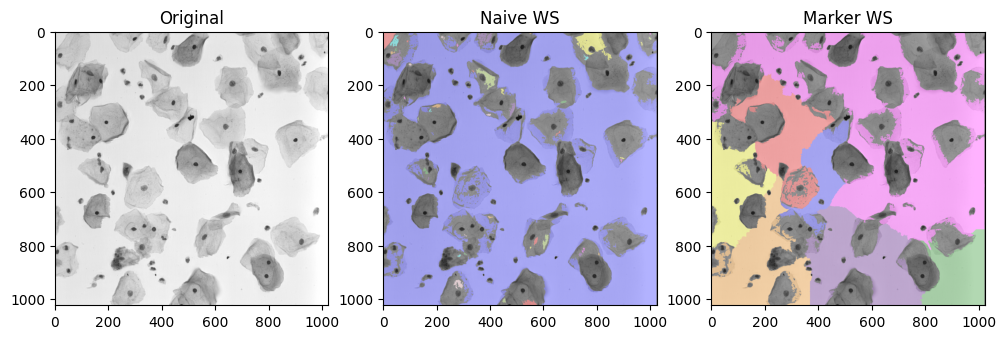

DICE NAIVE: 0.9437332068903558
DICE MARKER: 0.7127442996735416
IOU NAIVE: 0.8934610204997756
IOU MARKER: 0.5536928673098213


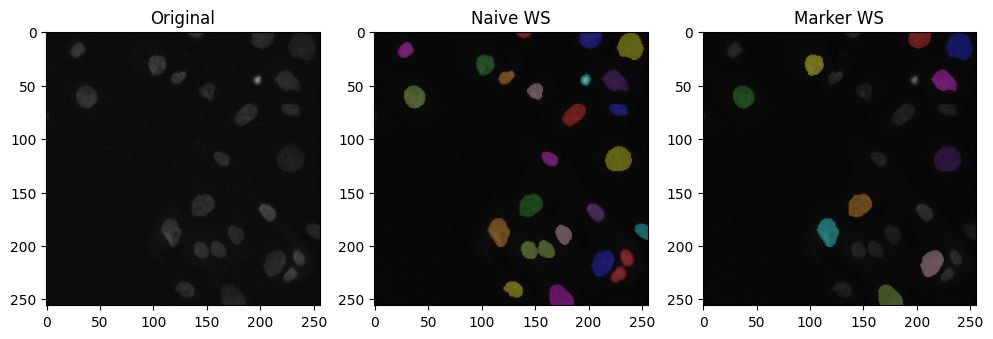

DICE NAIVE: 0.9123468425984532
DICE MARKER: 0.8179901616274843
IOU NAIVE: 0.8388214904679376
IOU MARKER: 0.6920332936979786


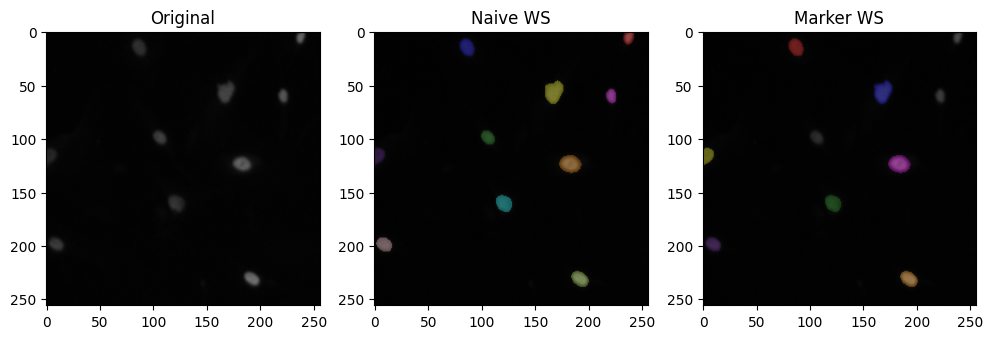

/tmp/ipython-input-697660322.py:2: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return morphology.remove_small_objects(labels.astype(int), min_size)


DICE NAIVE: 0.0026849935954277905
DICE MARKER: 0.0026849935954277905
IOU NAIVE: 0.0013443015181974027
IOU MARKER: 0.0013443015181974027


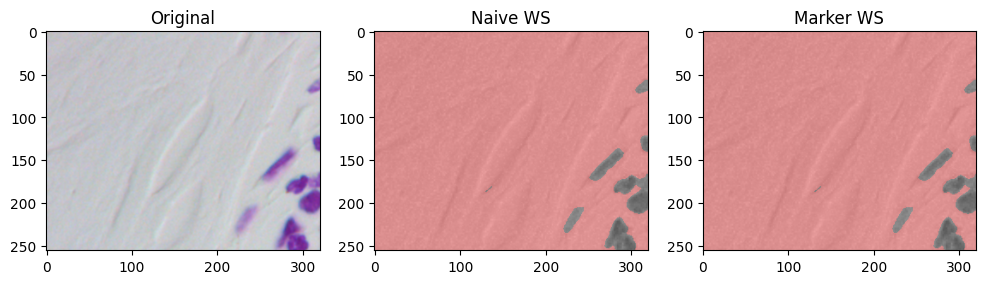

DICE NAIVE: 0.9098116947382575
DICE MARKER: 0.8652631578856288
IOU NAIVE: 0.8345454545454546
IOU MARKER: 0.7625231910946196


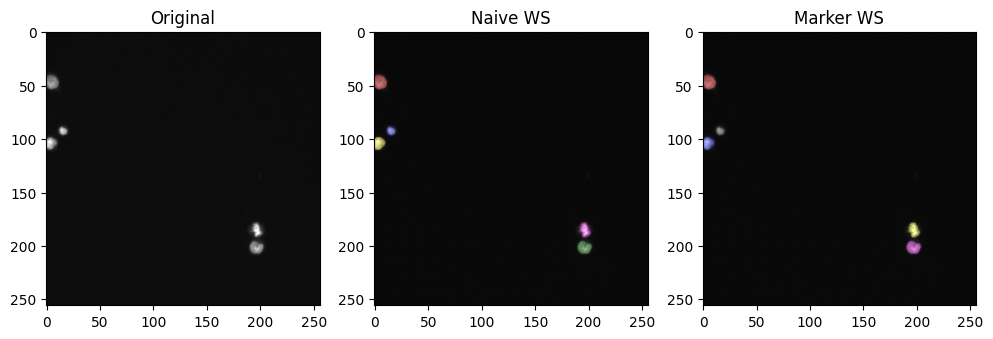

In [28]:
ids = os.listdir(TRAIN_PATH)[:5]

for image_id in ids:

    path = os.path.join(TRAIN_PATH, image_id)

    image, gt_mask = load_image_and_mask(path)

    gray, binary = preprocess(image)

    naive = naive_watershed(gray, binary)
    marker = marker_watershed(gray, binary)

    naive = remove_small(naive)
    marker = remove_small(marker)

    print("DICE NAIVE:", dice(gt_mask, naive))
    print("DICE MARKER:", dice(gt_mask, marker))
    print("IOU NAIVE:", iou(gt_mask, naive))
    print("IOU MARKER:", iou(gt_mask, marker))

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(image[:, :, :3]) # Display only RGB channels
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(overlay(image[:, :, :3], naive)) # Pass only RGB channels to overlay
    plt.title("Naive WS")

    plt.subplot(1,3,3)
    plt.imshow(overlay(image[:, :, :3], marker)) # Pass only RGB channels to overlay
    plt.title("Marker WS")

    plt.show()